In [1]:
%matplotlib inline
import torch
from torch import nn
import d2l_torch as d2l
import logging
import datetime
import importlib
import rnn_base
import os
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from PIL import Image
import d2l_torch as d2l
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.optim as optim
import sys
import random
import numpy as np

import pandas as pd
import os
from gensim.models import word2vec
import torch
from torch.utils import data
from torch import nn
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertConfig, DistilBertModel, AutoTokenizer, DistilBertTokenizer, BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_scheduler, DataCollatorWithPadding
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
from sklearn.model_selection import KFold
from accelerate import Accelerator
from torch.nn import BCEWithLogitsLoss

In [2]:
batch_size = 128
home_dir = '../data/kaggle_toxic/input/'
path_prefix = "../data/kaggle_toxic/save/"

In [3]:
max_features = 20000

In [4]:
for dirname, _, filenames in os.walk(home_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/kaggle_toxic/input/sample_submission.csv.zip
../data/kaggle_toxic/input/test.csv.zip
../data/kaggle_toxic/input/test_labels.csv.zip
../data/kaggle_toxic/input/train.csv.zip


In [5]:
df_train = pd.read_csv(os.path.join(home_dir,'train.csv.zip'),error_bad_lines=False)

In [6]:
df_train.iloc[0:4]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0


In [7]:
df_pred = pd.read_csv(os.path.join(home_dir,'test.csv.zip'),error_bad_lines=False)

In [8]:
df_pred.iloc[0:4]

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."


In [9]:
# list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
list_classes = [col for col in df_train.columns if df_train[col].dtypes == 'int64']
list_classes
# y = df_train[list_classes].values
# list_sentences_train = df_train["comment_text"]
# list_sentences_test = df_pred["comment_text"]

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [10]:
import re

# 停用词列表，可以根据需要进行扩展
stopwords = ["the", "and", "is", "on", "in", "if", "for", "a", "an", "of", "or", "to", "it", "you", "your"]

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove web links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove special characters, punctuation marks, and newlines
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove stopwords
    text = ' '.join(word for word in text.split() if word.lower() not in stopwords)

    return text.lower()

In [11]:
df_train['Cleaned_Comments'] = df_train['comment_text'].apply(clean_text)
df_train['Cleaned_Comments'].head()

0    explanation why edits made under my username h...
1    daww he matches this background colour im seem...
2    hey man im really not trying edit war its just...
3    more i cant make any real suggestions improvem...
4    sir are my hero any chance remember what page ...
Name: Cleaned_Comments, dtype: object

In [12]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
    wordcloud = WordCloud(width=800, height=400,stopwords=set(STOPWORDS), background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

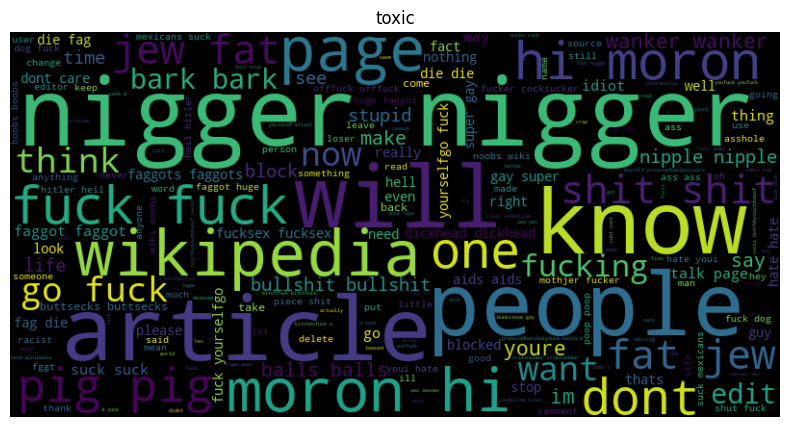

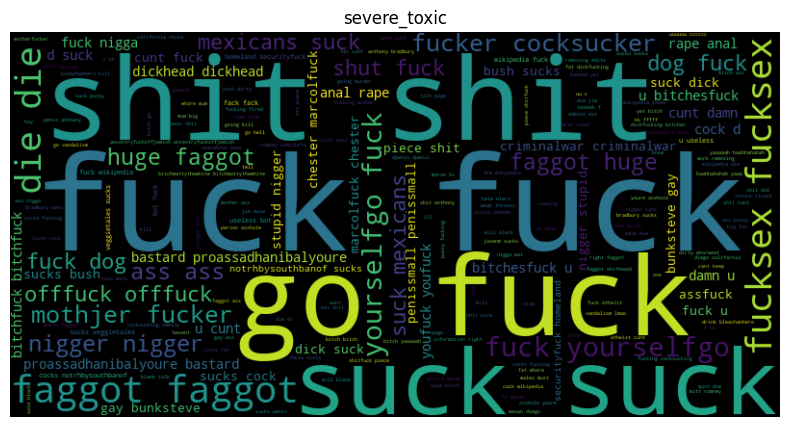

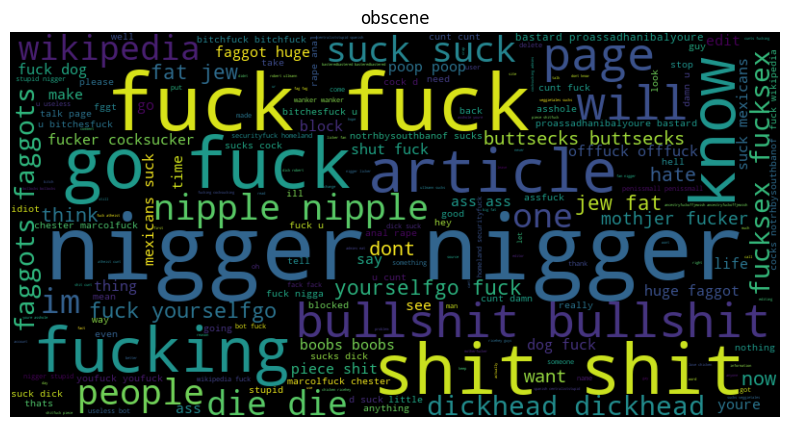

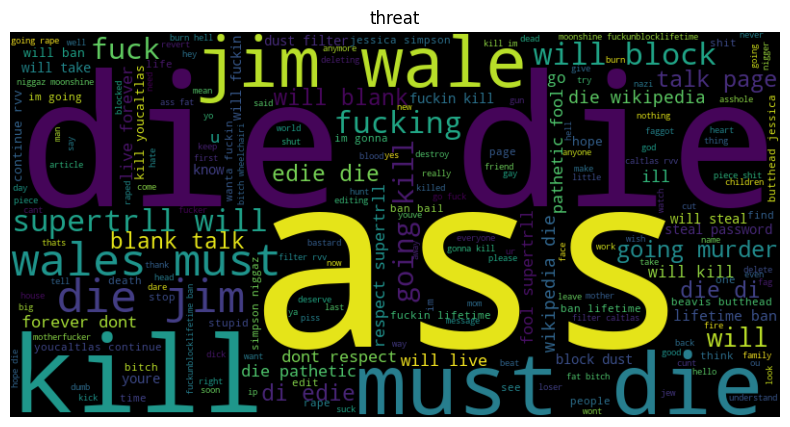

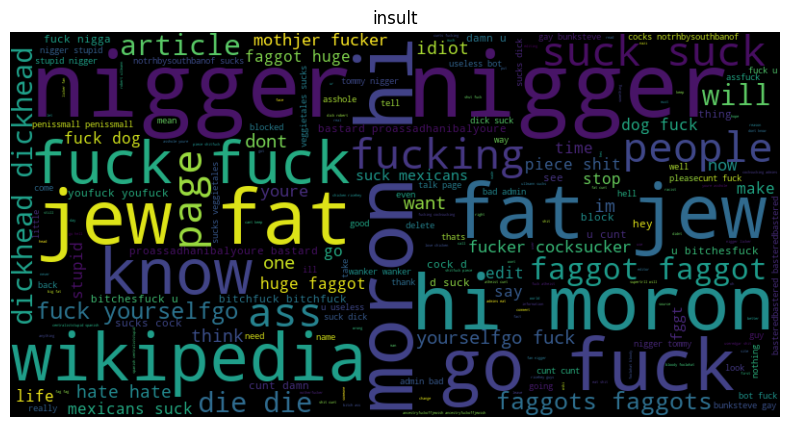

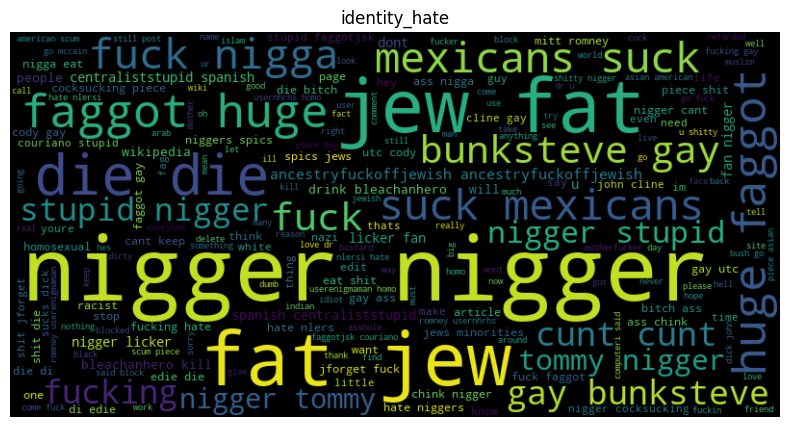

In [13]:
# Plot word clouds for each target label
for label in list_classes:
    text = ' '.join(df_train[df_train[label] == 1]['Cleaned_Comments'].values)
    generate_wordcloud(text,Title=label)

In [14]:
import re
def text_preprocessing(text):
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'[0-9]+' , '' ,text)
    text = re.sub(r'\s([@][\w_-]+)', '', text).strip()
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace("#" , " ")
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [15]:
#Load the Bert tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)

# Create a funcition to tokenize a set of text

def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []
    
    MAX_LEN = 150
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text = text_preprocessing(sent), #preprocess sentence
            add_special_tokens = True,
            max_length= MAX_LEN  ,
            pad_to_max_length = True,     
            return_attention_mask= True,
            return_tensors='pt'
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
        
    #convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    # input_ids = torch.cat(input_ids, dim=0)
    # attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids,attention_masks

In [16]:
def load_data_imdb(batch_size, num_steps=500):
    # df_labeledTrainData = pd.read_csv(os.path.join(home_dir,'train.csv.zip'),error_bad_lines=False)
    train_x, train_y = list(df_train['comment_text']), list(df_train[list_classes].values)
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    n_train = len(df_train)
    train_slices = random.sample(list(range(n_train)), int(round(n_train * 0.9, 0)))
    test_slices = list(set(range(n_train)) - set(train_slices))
    
    train_data = (train_x[train_slices], list(train_y[train_slices]))
    test_data = (train_x[test_slices], list(train_y[test_slices]))
    train_inputs, train_masks = preprocessing_for_bert(train_data[0])
    val_inputs, val_masks = preprocessing_for_bert(test_data[0])
    train_iter = d2l.load_array((train_inputs, train_masks, torch.tensor(train_data[1], dtype=torch.float)),
                                batch_size)
    test_iter = d2l.load_array((val_inputs, val_masks, torch.tensor(test_data[1], dtype=torch.float)),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter

In [17]:
def load_distilbert_data():
    checkpoint = "distilbert-base-uncased"
    distil_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    distil_tokens = [distil_tokenizer(a, max_length=512, truncation=True) for a in tqdm(df_train.comment_text.values, position = 0,leave=True)] 
    df_train['tokens'] = distil_tokens
    kf = KFold(n_splits=2)
    folds = dict()
    for i, (train_index, test_index) in enumerate(kf.split(df_train)):
        folds[i] = {'train':df_train.iloc[train_index], 'test':df_train.iloc[test_index]}
    train_datasets = []
    eval_datasets = []
    models =[]
    NUM_LABELS = len(list_classes)
    for i in folds:
        train_y = folds[i]['train'][list_classes].values
        valid_y = folds[i]['test'][list_classes].values

        train_dataset = folds[i]['train'].tokens.values
        for a,b in zip(train_dataset, train_y):
             a['label'] = b
        train_datasets.append(train_dataset)

        eval_dataset = folds[i]['test'].tokens.values
        for a,b in zip(eval_dataset, valid_y):
             a['label'] = b
        eval_datasets.append(eval_dataset)
        models.append(AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=NUM_LABELS))
    train_datasets=np.array(train_datasets)
    eval_datasets=np.array(eval_datasets)
    return distil_tokenizer, models, train_datasets, eval_datasets

In [18]:
# batch_size = 128
# print('load_data_imdb start: ', datetime.datetime.now())
# train_iter, test_iter = load_data_imdb(batch_size)
# print('load_data_imdb end:', datetime.datetime.now())

In [19]:
# for i,(x,y,z) in enumerate(train_iter):
#     print(x)
#     print(y.to(torch.int64))
#     print('----')
#     if i==2:
#         break

In [20]:
def load_data_imdb_infer(batch_size, num_steps=500):
    # df_test = pd.read_csv(os.path.join(home_dir,'test.csv.zip'),error_bad_lines=False)
    infer_x = list(df_pred['comment_text'])
    infer_inputs, infer_masks = preprocessing_for_bert(infer_x)

    infer_iter = d2l.load_array((infer_inputs,infer_masks),
                               batch_size,
                               is_train=False)
    return infer_iter

In [21]:
class BertClassifier(nn.Module):
    
    def __init__(self, freeze_bert=False):
        super(BertClassifier,self).__init__()
        
        # Specify hidden size of Bert, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50 , 6
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        self.classifier = nn.Sequential(
                            nn.Linear(D_in, H),
                            nn.ReLU(),
                            nn.Linear(H, D_out))
        
        # Freeze the Bert Model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    
    def forward(self,input_ids,attention_mask):

        outputs = self.bert(input_ids=input_ids,
                           attention_mask = attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:,0,:]
        
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        
        return logits

In [22]:
class DistilBertClassifier(nn.Module):
    
    def __init__(self, freeze_bert=False):
        super(DistilBertClassifier,self).__init__()
        
        # Specify hidden size of Bert, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50 , 6
        
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased", num_labels=6)
        
        self.classifier = nn.Sequential(
                            nn.Linear(D_in, H),
                            nn.ReLU(),
                            nn.Linear(H, D_out))
        
        # Freeze the Bert Model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    
    def forward(self,input_ids,attention_mask):

        outputs = self.bert(input_ids=input_ids,
                           attention_mask = attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:,0,:]
        
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        
        return logits

In [23]:
def initialize_model(epochs=4):

    # Define Bert Classifier
    bert_classifier = DistilBertClassifier(freeze_bert=False)
    
    bert_classifier.to(d2l.try_gpu())
    
    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),)
    
    # Total number of training steps
    total_steps = len(train_iter) * epochs
    
    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps=0, # Default
                                              num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [24]:
def train_figure(net, optimizer, scheduler, train_iter, test_iter, num_epochs, num_gpus):

    def accuracy(y_hat, y):
        category=y_hat
        # print('----')
        # print(category.shape)
        for j in range(y_hat.shape[0]):
            # print(category[j])
            temp = [0 if item<=0.5 else 1 for item in y_hat[j] ]
            # print(temp)
            # print(y.cpu())
        # return (y_hat.argmax(1) == y).sum()
        return 128

    print(net)
    model_path = os.path.join(path_prefix, 'toxic_bert_%s.pth' % num_epochs)
    result_csv_path = os.path.join(path_prefix, 'train_bert_detail_%s.csv' % num_epochs)
    print('model_path:', model_path)
    print('result_csv_path:', result_csv_path)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    print(devices)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    net.train()
    # loss = nn.BCELoss()
    loss = nn.BCEWithLogitsLoss()
    train_detail = pd.DataFrame(columns=['train_loss', 'test_loss', 'train acc', 'test acc'])
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train_loss', 'test_loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_loss_tot, train_acc_tot, train_tot = 0, 0, 0
        test_loss_tot, test_acc_tot, test_tot = 0, 0, 0
        net.train()
        for X, m, y in train_iter:
            optimizer.zero_grad()
            X, m, y = X.to(devices[0]), m.to(devices[0]), y.to(devices[0])
            y_hat = net(X, m)
            # print(y)
            # print('-----')
            # print(y_hat)
            l = loss(y_hat, y)
            l.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            with torch.no_grad():
                train_loss_tot += l * X.shape[0]
                train_acc_tot += accuracy(y_hat, y)
                train_tot += X.shape[0]
        net.eval()
        with torch.no_grad():
            for X, m, y in test_iter:
                X, m, y = X.to(devices[0]), m.to(devices[0]), y.to(devices[0])
                y_hat = net(X, m)
                test_loss_tot += l * X.shape[0]
                test_acc_tot += accuracy(y_hat, y)
                test_tot += X.shape[0]
        train_loss = train_loss_tot / train_tot
        train_acc = train_acc_tot / train_tot
        test_acc = test_acc_tot / test_tot
        test_loss = test_loss_tot / test_tot
        animator.add(epoch + 1, (train_loss.cpu(), test_loss.cpu(), train_acc, test_acc))
        train_detail.loc[len(train_detail)] = [train_loss.cpu(), test_loss.cpu(), train_acc, test_acc]
        # print('train_loss:', train_loss, '\ttrain_acc', test_acc, '\ttest_acc', test_acc)
        torch.save(net.state_dict(), model_path)
        train_detail.to_csv(result_csv_path, index=False)

In [25]:
def train_distil(_models,train_datasets, eval_datasets, _tokenizer, num_epochs, num_gpus):
    model_path = os.path.join(path_prefix, 'toxic_distil_%s.pth' % num_epochs)
    print('model_path:', model_path)
    BATCH_SIZE = 16
    NUM_LABELS = 6
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    data_collator = DataCollatorWithPadding(tokenizer=_tokenizer)
    for i in range(len(_models)):
        AUCs = []
        print('model', i)
        net = nn.DataParallel(_models[i], device_ids=devices).to(devices[0])
        print(net)
        optimizer = AdamW(net.parameters(), lr=1e-4)

        train_dataloader = DataLoader(
            train_datasets[i],
            batch_size=BATCH_SIZE,
            collate_fn = data_collator
        )

        eval_dataloader = DataLoader(
            eval_datasets[i],
            batch_size=BATCH_SIZE,
            collate_fn = data_collator
        )

        accelerator = Accelerator()
        train_dataloader, eval_dataloader, net, optimizer = accelerator.prepare(
            train_dataloader, eval_dataloader, net, optimizer
        )

        num_training_steps = num_epochs * len(train_dataloader)
        lr_scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=num_training_steps,
        )

        train_loss_set = []
        for epoch in range(num_epochs):
            print(f"epoch: {epoch}")
            tr_loss = 0
            nb_tr_examples, nb_tr_steps = 0, 0
            num_training_steps = len(train_dataloader)
            progress_bar = tqdm(range(num_training_steps))
            net.train()
            for batch in train_dataloader:
                optimizer.zero_grad()
                outputs = net(
                    batch['input_ids'],
                    attention_mask=batch['attention_mask'])
                logits = outputs[0]
                loss_func = BCEWithLogitsLoss() 
                loss = loss_func(logits.view(-1, NUM_LABELS),
                                 batch['labels'].type_as(logits).view(-1, NUM_LABELS))
                train_loss_set.append(loss.item())    
                accelerator.backward(loss)
                optimizer.step()
                lr_scheduler.step()
                tr_loss += loss.item()
                nb_tr_examples += batch['input_ids'].size(0)
                nb_tr_steps += 1
                progress_bar.update(1)
            progress_bar.close()
            print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # torch.save(net.state_dict(), model_path)

In [26]:
EPOCHS = 1
LR = 0.001
# bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
# train_figure(bert_classifier, optimizer, scheduler, train_iter ,test_iter, EPOCHS, 1)

_tokenizer, _models, train_datasets, eval_datasets = load_distilbert_data()

100%|██████████| 159571/159571 [00:29<00:00, 5490.48it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rongjoker\AppData\Local\Temp\ipykernel_25856\1980919270.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shape

In [27]:
train_distil(_models,train_datasets, eval_datasets, _tokenizer, 1, 1)

model_path: ../data/kaggle_toxic/save/toxic_distil_1.pth
model 0


C:\Users\rongjoker\anaconda3\envs\pandas\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


DataParallel(
  (module): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (f

100%|██████████| 4987/4987 [13:02<00:00,  6.37it/s]


Train loss: 0.05070685013927438
model 1
DataParallel(
  (module): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12,

100%|██████████| 4987/4987 [13:09<00:00,  6.32it/s]

Train loss: 0.051390602688697676


In [28]:
def testing(test_loader, epochs, num_gpus):
    model_path = os.path.join(path_prefix, 'toxic_bert_%s.pth' % epochs)
    print(model_path)
    model = DistilBertClassifier(freeze_bert=False)
    # 直接运行，acc 0.5
    # model.load_state_dict(torch.load(model_path), False)
    # 多卡 ，acc 0.9
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    model = nn.DataParallel(model, device_ids=devices).to(devices[0])
    model.load_state_dict(torch.load(model_path))
    
    model = model.to(d2l.try_gpu())
    model.eval()  # 设置模型为推理模式
    ret_output = []
    with torch.no_grad():
        for i, (b_input_ids, b_attn_mask) in enumerate(test_loader):
            b_input_ids, b_attn_mask = b_input_ids.to(d2l.try_gpu()), b_attn_mask.to(d2l.try_gpu())
            outputs = model(b_input_ids, b_attn_mask)
            outputs = outputs.squeeze()
            ret_output += outputs.tolist()
    
    return ret_output

In [29]:
# _infer_iter = load_data_imdb_infer(batch_size)
# ret_output = testing(_infer_iter, 4, 1)
# # df_pred = pd.read_csv(os.path.join(home_dir,'test.csv.zip'),error_bad_lines=False)
# submid = pd.DataFrame({'id': df_pred['id']})
# pred=pd.DataFrame(ret_output,columns = list_classes)
# # 寫到csv檔案供上傳kaggle
# submission = pd.concat([submid,pred], axis=1)
# submission.to_csv(os.path.join(path_prefix, 'bert_submission.csv'), index = False)
# print("Finish Predicting")

In [32]:
def testing_distil(_tokenizer, _models, num_gpus):
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    tokens_test = [_tokenizer(a, max_length=512, truncation=True) for a in tqdm(df_pred.comment_text, position = 0,leave=True)]
    BATCH_SIZE = 16
    data_collator = DataCollatorWithPadding(tokenizer=_tokenizer)
    test_dataloader = DataLoader(
    tokens_test,
    batch_size=BATCH_SIZE,
    collate_fn = data_collator)
    
    fold_preds = []
    progress_bar = tqdm(range(len(test_dataloader)), position=0, leave=True)
    for i in range(len(_models)):
        net = nn.DataParallel(_models[i], device_ids=devices).to(devices[0])
        preds = []
        net.eval()
        for batch in tqdm(test_dataloader, position=0, leave=True):
            batch = {k: v.to(devices[0]) for k, v in batch.items()}
            with torch.no_grad():
                outputs = net(**batch)
                logits = outputs.logits
                pred_probs = torch.sigmoid(logits)
                pred_probs = pred_probs.tolist()
                preds.extend(pred_probs)
            progress_bar.update(1)
        progress_bar.close()
        fold_preds.append(preds)
    dfs = [pd.DataFrame(a) for a in fold_preds]
    mean_probs = sum(dfs)/len(dfs)
    labels = mean_probs
    result = pd.DataFrame()
    result['id'] = df_test.id
    for a,b in zip(list_classes, labels):
        result[a]=labels[b]
    submission.to_csv(os.path.join(path_prefix, 'submission_distil.csv'), index = False)


In [33]:
testing_distil(_tokenizer, _models, 1)

100%|██████████| 9573/9573 [08:09<00:00, 19.54it/s]


NameError: name 'df_test' is not defined

In [ ]:
model_path = os.path.join(path_prefix, 'toxic_distil_%s.pth' % 1)\
net = nn.DataParallel(_models[0], device_ids=devices).to(devices[0])
torch.save(net.state_dict(), model_path)